In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'


# roi_2
# roi_2
roi_name = 'roi_2'

In [3]:
with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

In [27]:
## traditional barcode calling (using cutoff of 3)

df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df = df.set_index('object_id')

df.sort_index(inplace=True)

df['cell_id'] = df.index

barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] >= cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

total_bc_threshold = 10

# include cells with at least 10 barcode spots
has_bcs = df[df[barcode_cols].sum(axis=1) >= 10]
matrix = has_bcs[barcode_cols]

matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)
braycurtis_dist = scipy.spatial.distance.pdist(matrix_norm,metric='braycurtis')

braycurtis_dist_square = scipy.spatial.distance.squareform(braycurtis_dist)

threshold = 0.3
cluster = AggCluster(distance_threshold=threshold,n_clusters=None,linkage='average',affinity='precomputed').fit(braycurtis_dist_square)

gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])


cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes']
# for col in :
#     adata_genes.obs[col] = df[col]




No filtering available or applied.


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_86185/690825495.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cell_id'] = df.index
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


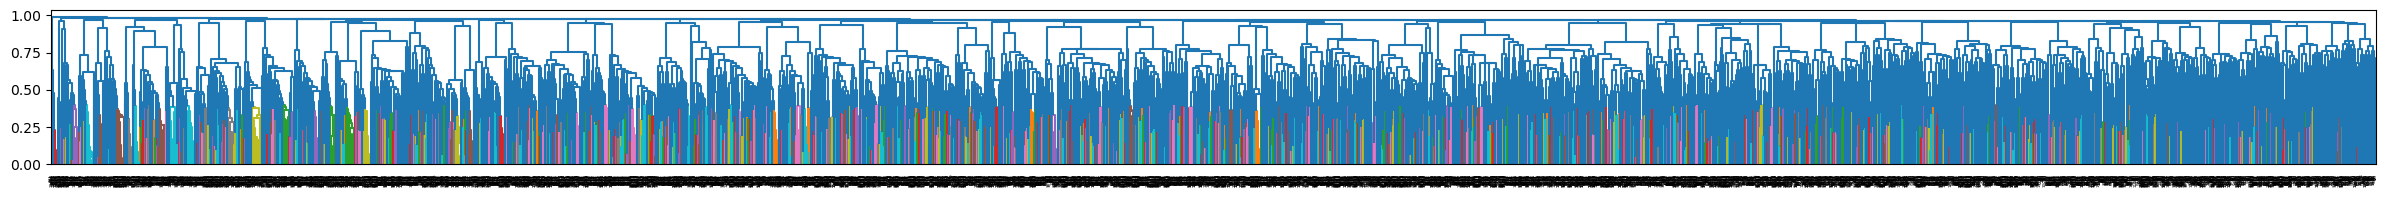

In [5]:
plt.figure(figsize=(30,2))

# labels_here = [l if l.count('_') > 2 else '' for l in has_bcs['barcode_names'].values[random_indices]]
# plot_dendrogram(cluster,labels=has_bcs['barcode_names'].values[random_indices],leaf_rotation=90,leaf_font_size=6,color_threshold=0.5, truncate_mode="level",)
tools.plot_dendrogram(cluster,leaf_rotation=90,leaf_font_size=3,color_threshold=threshold, truncate_mode="level",)

# plot_dendrogram(cluster,labels=labels_here,leaf_rotation=90,leaf_font_size=2)

In [6]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [12]:
score_list = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7]

for score in score_list:
    closest_score = find_nearest(braycurtis_dist,score)

    loc = (np.where(braycurtis_dist_square==closest_score)[0][0],np.where(braycurtis_dist_square==closest_score)[1][0])
    # print(score,loc)

    # print(has_bcs[['cell_id','']].iloc[list(loc),:])

    this_pair = has_bcs.iloc[list(loc),:]

    # show only barcode columns where the sum is non zero
    cols_to_show = [col for col in this_pair[barcode_cols].columns if this_pair[col].sum() > 0]
    cols_to_show = ['cell_id','barcode_names','n_called_barcodes'] + cols_to_show
    print(score)
    print(this_pair[cols_to_show])

0.1
           cell_id                barcode_names  n_called_barcodes  bc_002  \
object_id                                                                    
10990.0    10990.0  bc_029-bc_039-bc_041-bc_085                  4     0.0   
11134.0    11134.0  bc_029-bc_039-bc_041-bc_085                  4     1.0   

           bc_029  bc_035  bc_039  bc_041  bc_070  bc_085  
object_id                                                  
10990.0      19.0     0.0    24.0    32.0     1.0    19.0  
11134.0      30.0     1.0    23.0    44.0     0.0    35.0  
0.2
           cell_id barcode_names  n_called_barcodes  bc_027  bc_028  bc_069  \
object_id                                                                     
424.0        424.0        bc_090                  1     1.0     0.0     1.0   
12200.0    12200.0        bc_090                  1     0.0     1.0     0.0   

           bc_076  bc_090  
object_id                  
424.0         0.0    19.0  
12200.0       2.0    12.0  
0.25
     

In [23]:
ix = np.where(has_bcs['cell_id'].isin([4946,5014]))[0]

In [25]:
ix

array([4166, 4230])

In [26]:
braycurtis_dist_square[ix[0],ix[1]]

0.657665853732579

In [9]:
find_nearest(braycurtis_dist,0.1)

0.1000000003259629

In [10]:
find_nearest(braycurtis_dist,0.2)

0.2